# VAST Challenge : Les Viz'Iteurs

<img src="American-Pipit.jpg" alt="drawing" width="700"/>


# Introduction

In this Notebook, we're going to present you our work concerning the VAST Challenge. 

Through several complementary analysis, we're going to address the main problem here : Has Kasios polution had an impact on the Rose-Crested blue Pitit natural environment ?

# I. Exploration of the dataset


In [20]:
path = ''

In [21]:
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


import numpy as np
import pandas as pd
from datetime import date, datetime, timedelta
from time import sleep

from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook, show, curdoc
from bokeh.palettes import Category20
from bokeh.transform import factor_cmap
from bokeh.layouts import layout, column, row
from bokeh.models import ColumnDataSource, HoverTool, Plot, LinearAxis, Grid, CustomJS
from bokeh.models.widgets import MultiSelect, DateRangeSlider
from bokeh.models.glyphs import ImageURL

import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
# Data importation
geo = pd.read_csv(path+'AllBirdsv4.csv', sep=',', header=0, encoding='utf-8')
geo.head()

,File ID,English_name,Vocalization_type,Quality,Time,Date,X,Y
0,402254,Rose-crested Blue Pipit,call,no score,13:30,2/8/2018,49,63
1,406171,Rose-crested Blue Pipit,call,A,7:48,6/7/2017,125,133
2,405901,Rose-crested Blue Pipit,call,A,12:00,2/8/2018,58,76
3,405548,Rose-crested Blue Pipit,song,A,11:00,3/10/2018,55,125
4,401782,Rose-crested Blue Pipit,song,A,6:00,6/29/2008,129,123


## Data Cleaning

In [23]:
def description(dataframe=geo):
    """
    This function allows us to describe the dataset we have.

    input : 
        dataframe : dataframe to describe
    """
    print(dataframe.columns)
    print('---------')
    print(dataframe.info())
    print('---------')
    print(dataframe.describe(include='all'))
    print('---------')
    print('NA values for X column :' + str(dataframe['X'].isna().sum()))
    print('NA values for Y column : ' + str(dataframe['Y'].isna().sum()))
    for i in dataframe.columns:
        print(':::::')
        print(i)
        print(len(dataframe[i].unique()))
        if (len(dataframe[i].unique()) <= 20):
            print(dataframe[i].unique())
    print('---------')
    print(dataframe.head())

In [24]:
def codify(column):
    """
    This function allows to convert labels of categorical data into numbers -
    still categorical

    input : 
        column : column to convert
    """
    return pd.Categorical(column).codes

In [25]:
# Vocalization_type labels to correct (strip, lower and clean)
print("Before cleaning of Vocalization_type : {}".format(
    geo['Vocalization_type'].unique()))
geo['Vocalization_type'] = geo['Vocalization_type'].str.strip()
geo['Vocalization_type'] = geo['Vocalization_type'].str.lower()
geo['Vocalization_type'] = geo['Vocalization_type'].replace('?', None)
print("After cleaning of Vocalization_type : {}".format(
    geo['Vocalization_type'].unique()))

#Dates are of three different formats
geo['Date_Temp'] = pd.concat([
    pd.to_datetime(geo['Date'], errors='coerce', format="%m/%d/%Y").dropna(),
    pd.to_datetime(geo['Date'], errors='coerce', format="%Y-%m-%d").dropna(),
    pd.to_datetime(geo['Date'], errors='coerce', format="%Y-%m-00").dropna()
], axis=0)

geo = geo.loc[~geo['Date_Temp'].isna()].copy()
geo['Year'] = geo['Date_Temp'].dt.year
geo['Diff_date'] = (max(geo['Date_Temp'])-geo['Date_Temp']).dt.days
geo['cod_English_name'] = codify(geo['English_name'])
geo['cod_Vocalization_type'] = codify(geo['Vocalization_type'])
geo['cod_Quality'] = codify(geo['Quality'])
geo["Y"] = geo["Y"].map(lambda y: str(y).replace("?", ""))
geo["Y"] = geo["Y"].astype('int64')
geo['Distance_kasios'] = ((geo['X']-148)**2+(geo['Y']-159)**2)**0.5

# 2603 est le troisieme quartile
geo['Diff_date_norm'] = 1 - geo['Diff_date'] / 2603
geo.loc[geo.loc[:,'Diff_date_norm'] >= 1]['Diff_date_norm'] = 1
geo.loc[geo.loc[:,'Diff_date_norm'] <= 0]['Diff_date_norm'] = 0
geo = geo.dropna()
geo.head()

Before cleaning of Vocalization_type : ['call' 'song' 'Song' 'call, song' '?' 'Call' 'Call, song' ' call' 'scold'
 'drumming' 'bill-snapping']
After cleaning of Vocalization_type : ['call' 'song' 'call, song' 'scold' 'drumming' 'bill-snapping']


,File ID,English_name,Vocalization_type,Quality,Time,Date,X,Y,Date_Temp,Year,Diff_date,cod_English_name,cod_Vocalization_type,cod_Quality,Distance_kasios,Diff_date_norm
0,402254,Rose-crested Blue Pipit,call,no score,13:30,2/8/2018,49,63,2018-02-08,2018,37,16,1,5,137.902139,0.985786
1,406171,Rose-crested Blue Pipit,call,A,7:48,6/7/2017,125,133,2017-06-07,2017,283,16,1,0,34.713110,0.891279
2,405901,Rose-crested Blue Pipit,call,A,12:00,2/8/2018,58,76,2018-02-08,2018,37,16,1,0,122.429572,0.985786
3,405548,Rose-crested Blue Pipit,song,A,11:00,3/10/2018,55,125,2018-03-10,2018,7,16,5,0,99.020200,0.997311
4,401782,Rose-crested Blue Pipit,song,A,6:00,6/29/2008,129,123,2008-06-29,2008,3548,16,5,0,40.706265,-0.363043


In [26]:
geo.head()

,File ID,English_name,Vocalization_type,Quality,Time,Date,X,Y,Date_Temp,Year,Diff_date,cod_English_name,cod_Vocalization_type,cod_Quality,Distance_kasios,Diff_date_norm
0,402254,Rose-crested Blue Pipit,call,no score,13:30,2/8/2018,49,63,2018-02-08,2018,37,16,1,5,137.902139,0.985786
1,406171,Rose-crested Blue Pipit,call,A,7:48,6/7/2017,125,133,2017-06-07,2017,283,16,1,0,34.713110,0.891279
2,405901,Rose-crested Blue Pipit,call,A,12:00,2/8/2018,58,76,2018-02-08,2018,37,16,1,0,122.429572,0.985786
3,405548,Rose-crested Blue Pipit,song,A,11:00,3/10/2018,55,125,2018-03-10,2018,7,16,5,0,99.020200,0.997311
4,401782,Rose-crested Blue Pipit,song,A,6:00,6/29/2008,129,123,2008-06-29,2008,3548,16,5,0,40.706265,-0.363043


In [27]:
def plotstack(column, percentage=False, elements=None) : 
    if elements : 
        df = geo[geo[column].isin(elements)]
    else :
        df = geo
    pvt = df.pivot_table(index=['Year'], columns=column, aggfunc='count')['Date']
    #pvt = df.pivot_table(index=['Date_Temp'].month, columns=column, aggfunc='count')['Year']
    if percentage :
        pvt = pvt.divide(pvt.sum(axis=1), axis=0)
    pvt.plot.area(
    figsize=(5, 5),
    title="Record {} for each year".format(column),
    legend='reverse'
    )

In [28]:
def plotline(column, percentage=False, elements=None) : 
    """
    Plots line of appearance as a function of Year Record
    inputs : 
        -column : the column to plot
        -percentage : whether you want it to be shown as percentage
        -elements : the elements of the column you want to use (use this arg to get only a few columns)
    """
    if elements : 
        df = geo[geo[column].isin(elements)]
    else :
        df = geo
    pvt = df.pivot_table(index=['Year'], columns=column, aggfunc='count')['Date']
    if percentage :
        pvt = pvt.divide(pvt.sum(axis=1), axis=0)
    pvt.plot.line(
        figsize=(5, 5),
        title="Record {} for each year".format(column),
        legend='reverse'
        )
#plotline('Vocalization_type', False)

In [29]:
def plotheat(column, df=geo) :
    fig, ax = plt.subplots(figsize=(20,5))
    pvt = df.pivot_table(index='Year', columns=column, aggfunc='count')['Date']
    sns.heatmap(pvt.T, cmap='Reds', annot=True)

## Statistical exploration

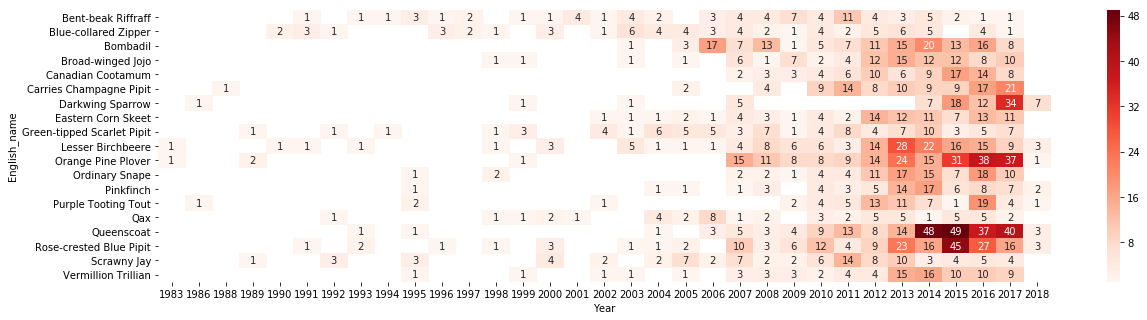

In [30]:
plotheat('English_name')
#plotstack('English_name', True)

With this heatmap, we can see that most of the records happened during the last years.

First hint concerning the Rose-crested Blue Pipit : There were 45 records of this specie before the incident, while only 27 the year after.

<Figure size 720x720 with 0 Axes>

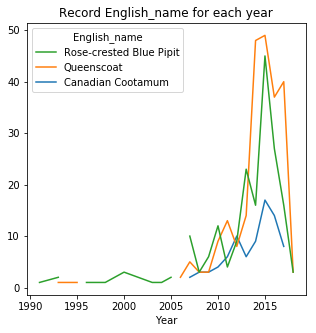

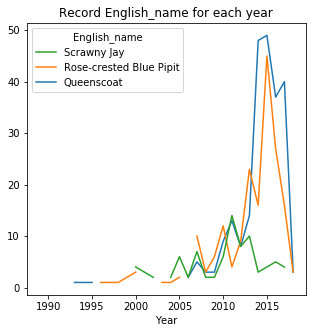

In [187]:
fig = plt.figure(figsize= (10,10))
plotline('English_name', percentage=False, elements=['Rose-crested Blue Pipit', 'Queenscoat', 'Canadian Cootamum'], )
plotline('English_name', percentage=False, elements=['Rose-crested Blue Pipit', 'Queenscoat', 'Scrawny Jay'], )
plt.show()

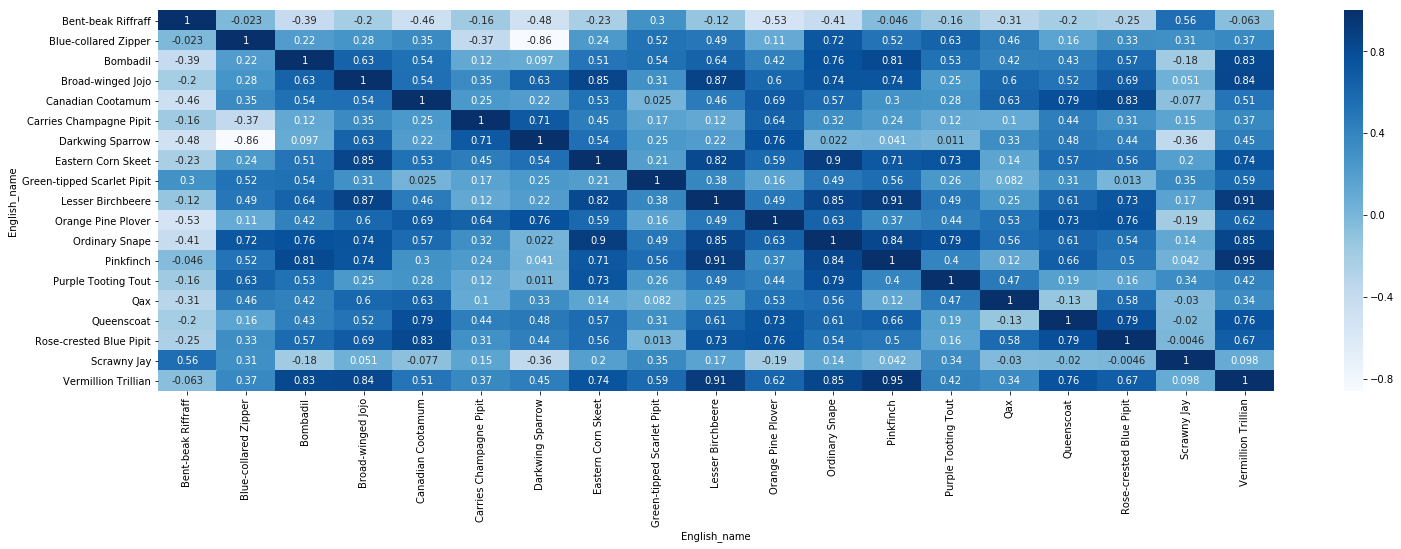

In [101]:
fig, ax = plt.subplots(figsize=(25,7))
pvt = geo.pivot_table(index=['Year'], columns='English_name', aggfunc='count')['Date']
sns.heatmap(pvt.corr(), annot=True, cmap='Blues')

### Several Hints:

Through the years, the number of records, in general and per species, isn't stable.

However, both the correlation matrix and the line-plot showed that populations of RCBP and Queenscoat seem very look-alike, while Canadian Cootamum has the same shape, but not the same amplitude. 

If we can't find any relevant informations by analysing RCBP only, we might need to use these correlations.

In [ ]:
#plotheat('Quality')
fig = plt.figsize(10, 10)
plotstack('Quality', True)

80% of the records are at least B-quality, which is a good score

## Geographical exploration

In [34]:
from bokeh import *
from bokeh.palettes import Category20

In [85]:
#pip install bokeh
#pip install pscript

import numpy as np
import pandas as pd
from datetime import date, datetime, timedelta
from time import sleep

from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook, show, curdoc
from bokeh.palettes import Category20
from bokeh.transform import factor_cmap
from bokeh.layouts import layout, column, row
from bokeh.models import ColumnDataSource, HoverTool, Plot, LinearAxis, Grid, CustomJS
from bokeh.models.widgets import MultiSelect, DateRangeSlider
from bokeh.models.glyphs import ImageURL

output_notebook()

##Import and Clean AllBirds
geo = pd.read_csv(path+"AllBirdsv4.csv")
geo['Vocalization_type'] = geo['Vocalization_type'].str.strip()
geo['Vocalization_type'] = geo['Vocalization_type'].str.lower()
geo['Vocalization_type'] = geo['Vocalization_type'].replace('?', None)
geo['Vocalization_type'].unique()
geo['Date'] = pd.to_datetime(geo['Date'], format='%m/%d/%Y', errors='coerce')
geo['cod_English_name'] = pd.Categorical(geo['English_name']).codes
geo['cod_Vocalization_type'] = pd.Categorical(geo['Vocalization_type']).codes
geo['cod_Quality'] = pd.Categorical(geo['Quality']).codes
geo['Y'] = pd.to_numeric(geo['Y'], errors='coerce')
geo['Year'] = geo['Date'].dt.year
geo['Distance_kasios'] = ((geo['X']-148)**2+(geo['Y']-159)**2)**0.5
geo['Diff_date']=(max(geo['Date'])-geo['Date']).dt.days
geo=geo.dropna()

#Add Colors for type of Birds
birds_types = geo['English_name'].sort_values().unique()
n_birds_types = len(birds_types)
birds_types_colors = pd.Series(Category20[n_birds_types], index = birds_types).rename('color')
geo = geo.join(birds_types_colors, on = "English_name") 

# Import Kassios Birds
K_birds=pd.read_csv(path+"Test Birds Location.csv", sep=',',header=0)
K_birds.columns=['Id', 'X', 'Y']

startdate = pd.to_datetime(geo['Date'].sort_values().unique()[0])
enddate = pd.to_datetime(geo['Date'].sort_values().unique()[-1])

def birds_map(doc):

    source = ColumnDataSource(data=dict(x=geo['X'], y=geo['Y'], color=geo['color'], date=geo['Date'], English_name = geo['English_name']))
    
    p = figure(title="Map with birds through time", x_range=(0, 200), y_range=(0, 200))
    
    #background image
    p.image_url( url=[r"images/compresspng/map.png"],x=0, y=0, w=200, h=200, anchor="bottom_left")
    
    #plot info when passing with mouse
    hover = HoverTool()
    hover.tooltips = [
        ("Bird type", "@English_name"),
        ("Position", "(@x, @y)"),
    ]
    p.tools.append(hover)
    
    #points
    p.circle(x='x', y='y', size=10, color='color', source=source)

    #Add Kassios Birds 
    source_kassios = ColumnDataSource(data=dict(x=K_birds['X'], y=K_birds['Y'], English_name = K_birds['Id']))
    p.scatter(x="x", y="y", size=30, marker="ox", fill_alpha=0.2, line_width=2, source=source_kassios, legend="Kassios Birds")

    #Kassios Entreprise location
    source_dumping = ColumnDataSource(data=dict(x=[148], y=[159], English_name=[""]))
    p.scatter(x="x", y="y", size=50, marker="o+", color="#B22222", fill_alpha=0.2, line_width=2, source=source_dumping, legend="Kassios Entreprise")

    #Widgets
    input_bird_types = MultiSelect(title="Species", options= list(birds_types) , size = n_birds_types)
    date_range_slider = DateRangeSlider(title="Date Range: ", start=startdate, end=enddate, value=(startdate, enddate), step=1)
    
    def update():  
        bird_types = input_bird_types.value
        selector_types = geo['English_name'].isin(bird_types)
        date_range = date_range_slider.value_as_datetime
        selector_date = (pd.to_datetime(geo['Date']) > date_range[0]) & ( pd.to_datetime(geo['Date'])<= date_range[1])
        geo_selected = geo.loc[selector_types & selector_date].copy() # Selection
        source.data = dict(
            x=geo_selected['X'],
            y=geo_selected['Y'],
            color=geo_selected["color"],
            date=geo_selected["Date"],
            English_name=geo_selected["English_name"],
        )
        
    #callbacks
    input_bird_types.on_change('value', lambda attr, old, new: update())
    date_range_slider.on_change('value', lambda attr, old, new: update())
    
    #display widget
    l = column(row(p,column(input_bird_types,date_range_slider)))
    doc.add_root(l)

Loading BokehJS ...

In [86]:
show(birds_map)

## Conclusion

Finally, we have obtained some interesting informations : First, some vocalization types are very rare, and we have to focus on singing and calling. Then, more than 80% of the records are in a good quality. The number of records increased neatly during the last ten years.

Then, we have seen 2 very high-density zones of birds and some few denses others. Kasios plant is on a medium-density zone. 

The specie that we want to study : Rose-crested Blue Pipits, are located near Kasios plant originally. Their record number is highly correlated with Queenscoats, which barycenter is located further west.

Kasios records are strangely located, they should not concern Rose-crested Blue Pipits, because it is very far from their original location.

# II. Birds sounds analysis for features extraction

## Basic Time representation of a Blue Pipit call

- We create the document name from the CSV file content.
- We pick one of the record
- We loads and decodes the audio as a time series y, represented as a one-dimensional NumPy floating point array. 
- The variable sr contains the sampling rate of y, that is, the number of samples per second of audio.


In [37]:
import tensorflow
import librosa
import librosa.display
import matplotlib.pyplot as plt

import scipy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn import metrics 
from sklearn.model_selection import train_test_split

from matplotlib.pyplot import specgram
from keras.utils import np_utils


train=pd.read_csv('AllBirdsv4.csv')
train.rename(columns={'File ID': 'File_ID'}, inplace=True)

def parser_2(row) :
    File_ID = str(train[row:row+1].File_ID.item())
    English_name = str(train[row:row+1].English_name.item()).replace(" ", "-")
    filename = 'ALL BIRDS/'+English_name+'-'+File_ID+'.mp3'
    #print(filename)
    y,sr=librosa.load(filename)
    return y, sr


In [19]:
y, sr = parser_2(15)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Boulanger Petite For\\Desktop\\DataVis\\VAST_mini_Challenge\\ALL_BIRDS\\Master2.0\\ALL BIRDS\\Rose-crested-Blue-Pipit-298739.mp3'

In [38]:
train=pd.read_csv('AllBirdsv4.csv')
train.rename(columns={'File ID': 'File_ID'}, inplace=True)

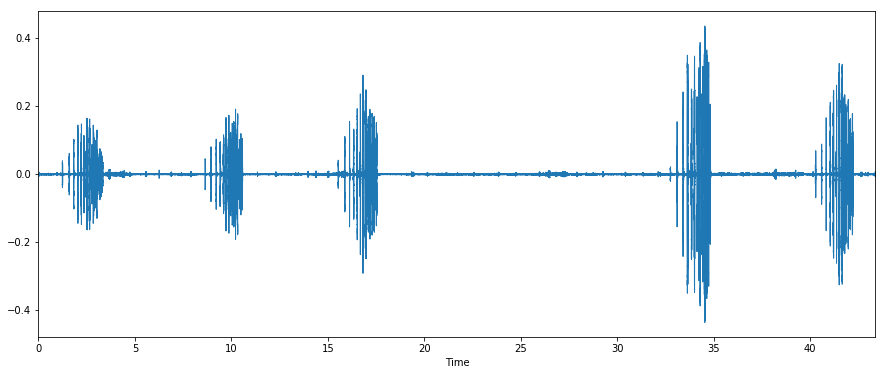

In [188]:
#y,sr=librosa.load('Rose-crested-Blue-Pipit-405548.mp3')
#fft = np.abs(librosa.stft(y))
fig = plt.figure(figsize=(15, 6)) 
librosa.display.waveplot(y)
tempo_Bpipit, beat_frames_Bpipit = librosa.beat.beat_track(y, sr)

In [ ]:
Y = []
Tempo = []
FFT = []

for i in range(15):
    y, sr = parser_2(i)
    fft = np.abs(librosa.stft(y))
    tempo, beat_frames = librosa.beat.beat_track(y, sr)
    Y.append(y)
    FFT.append(fft)
    Tempo.append(tempo)
    librosa.display.waveplot(y)
    

### Basic Frequential representation and filtering representation


In [41]:
#FFT_db = [librosa.amplitude_to_db(FFT[i], ref = np.min) for i in range (len(FFT))]

Sound = 1
#FFT_db = [librosa.amplitude_to_db(FFT[i], ref=0.00002) for i in range (len(FFT))]
#Filtered_FFT = [librosa.amplitude_to_db(FFT[i], ref = 0.00002) for i in range (len(FFT))]
T = 521

Y = []
FFT = []

y,sr=librosa.load('Rose-crested-Blue-Pipit-405548.mp3')
fft = np.abs(librosa.stft(y))
Y.append(y)
FFT.append(fft)

y,sr=librosa.load('Rose-crested-Blue-Pipit-401782.mp3')
fft = np.abs(librosa.stft(y))
Y.append(y)
FFT.append(fft)

y,sr=librosa.load('Rose-crested-Blue-Pipit-377874.mp3')
fft = np.abs(librosa.stft(y))
Y.append(y)
FFT.append(fft)

## Concepts

### Time representation

When listening to birdsong, we can easily see that each song has a distinct rhythmic and melodic structure. 

Songs of individual birds from same species sound similar to each other and differ from those of other species.

Quiet early in history, we've used the sonogram to transform a sound into a simple static visual image revealing the time-frequency structure of each song syllable. 

Sonogram images can be measured, analyzed, and compared with one another. This allows the researcher to quantify the degree of similarity between different songs by inspecting (or cross-correlating) sonograms and categorizing song syllables into distinct types. 

When recording a singing bird, the microphone capture tiny fluctuations in air pressure we call sound waves and turn those into an electrical current, which might look like this:
<img src="sonogram.png" alt="drawing" width="700"/>

As we can see, the bird call does not look like a simple wave. That is because it is composed of several differents frequencies, or several "pure waves"

<img src="Decomposed.png" alt="drawing" width="500"/>




### Frequential Representation

Then, appeared the fast Fourier transform (FFT) : an algorithm to compute the periodic structure in the signal, and representing it by a set of sine waves, called frequencies. Plotting the power of each one of those frequencies for the previous bird sound gives :

<img src="FFT.png" alt="drawing" width="400"/>


Then, we finally repeat this procedure for overlapping time windows and use an appropriate color set to represent the evolution of frequencies and their "intensity" over the full sample.

<img src="SpectroBuilding.png" alt="drawing" width="900"/>


#### First Approach : Manual Filtering and spectrum

In this part our main idea is to filter noises. When listening to records, one can hear lots of noises which can deteriorate our analyses.

We decided to filter noises. Our first idea has been to keep only frequencies that can be produced by birds (between 100Hz and 10kHz). It doesn't remove any noise because it is already the only domain of freqencies included in records.

So we filtered by amplitude, removing all frequencies for which amplitude was too low. We only kept 10% of them.

In [42]:
def high_amplitude_db (FFT):#We only keep the 10% highest amplitude frequencies
    Filtered_FFT_amp = [librosa.amplitude_to_db(FFT[i], ref = np.min) for i in range (len(FFT))]
    for i in range (len(FFT)):
        Filtered_FFT_amp[i][Filtered_FFT_amp[i]<np.percentile(Filtered_FFT_amp[i],95)] = np.min(FFT[i])
    return (Filtered_FFT_amp)


In [43]:
Filtered_FFT_db = high_amplitude_db (FFT)
FFT_db = [librosa.amplitude_to_db(FFT[i], ref = np.min) for i in range (len(FFT))]

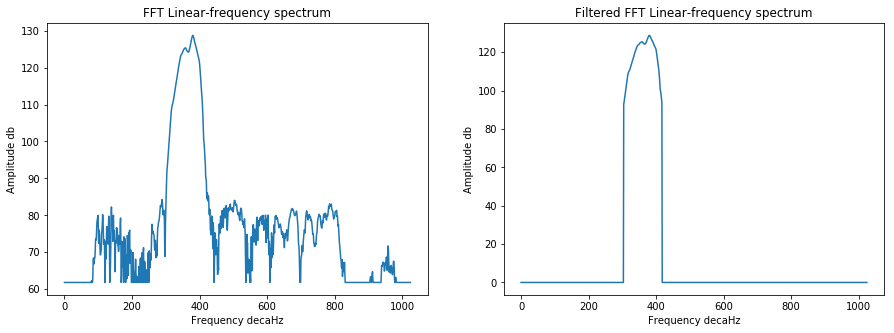

In [44]:
fig = plt.figure(figsize=(15, 5)) 
plt.subplot(121)
plt.plot(FFT_db[Sound][:, T])
plt.ylabel('Amplitude db')
plt.xlabel('Frequency decaHz')
plt.title('FFT Linear-frequency spectrum')

#for i in range (len(FFT)):
#    Filtered_FFT[i][Filtered_FFT[i]<np.percentile(Filtered_FFT[i],95)] = np.min(FFT_db[Sound][:, T])
plt.subplot(122) 
plt.plot(Filtered_FFT_db[Sound][:, T])
plt.ylabel('Amplitude db')
plt.xlabel('Frequency decaHz')
plt.title('Filtered FFT Linear-frequency spectrum')
plt.show()

More exactly, the bird sound was composed of different frequences, as shown after. These are the different peaks we can see on the Power Spectrum above


### Representing Simple Spectrogram
Spectrogram is an aggragation of spectrum.
As we add a dimention (time), we add a color scale to represent amplitude (db)
<img src="Spectrogram_Plot1.jpg" alt="drawing" width="900"/>

Text(0.5,1,'Filtered FFT Linear-frequency power Spectrogram')

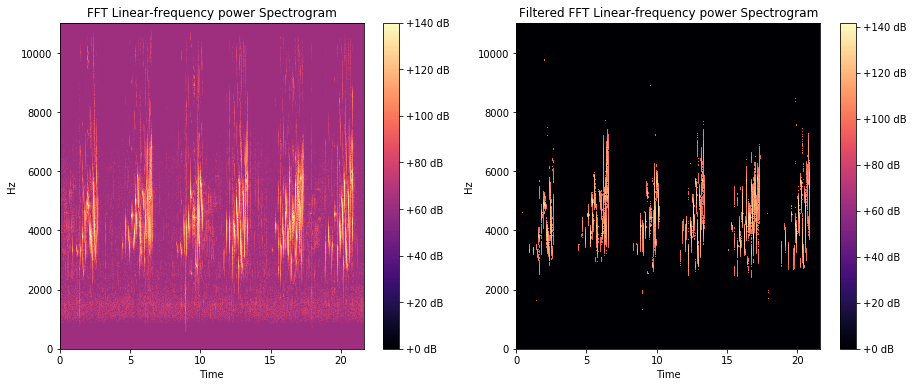

In [45]:
Sound = 1
fig = plt.figure(figsize=(15, 6)) 
plt.subplot(121)
librosa.display.specshow(FFT_db[Sound], y_axis = 'linear', x_axis='time')
plt.clim(0,140)
plt.colorbar(format='%+2.0f dB')
plt.title('FFT Linear-frequency power Spectrogram')
#ie power spectrogram

plt.subplot(122)
librosa.display.specshow(Filtered_FFT_db[Sound], y_axis = 'linear', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Filtered FFT Linear-frequency power Spectrogram')

### Energy reprensentation

Here we re-aggregate global energy (by integrating amplitude over frequencies). It is another way to compare filter and unfiltered records.

We will see two interestings things onth graphs : 
- a gap between scales (first plots)
- smoothing of parts without bird singing (best shown on third and fourth graphs)


- First representation (same scale)
<img src="Energy_representation1.jpg" alt="drawing" width="900"/>

- Second representation (different scales used : better way to emphasize smoothing of only noise parts).
<img src="Energy_representation2.jpg" alt="drawing" width="900"/>

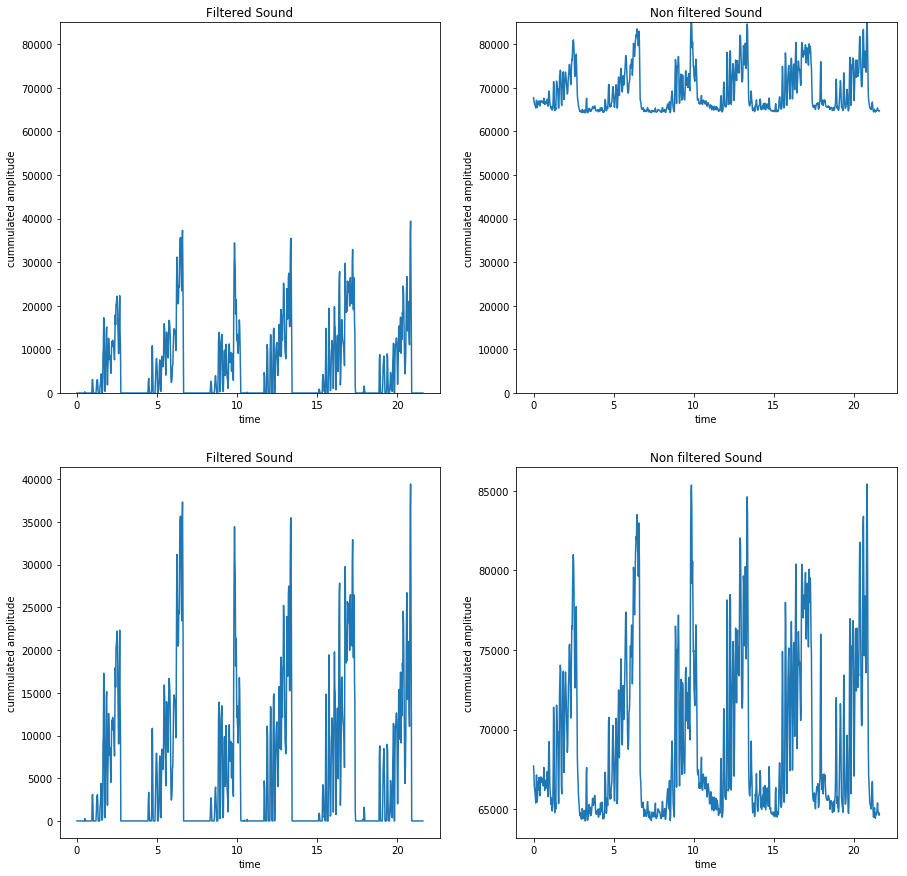

In [46]:
#Intégration
duration = librosa.core.get_duration(Y[Sound], sr=22050, S=None, n_fft=2048, hop_length=512, center=True, filename=None)
Int_filtered = np.sum(Filtered_FFT_db[Sound], axis =0)
Int_unfiltered = np.sum(FFT_db[Sound], axis =0)

time_axis = np.arange (0, duration, (duration/len(Int_filtered)))


fig = plt.figure(figsize=(15, 15))
#deux premiers plots même échelle pour que l'on se rende bien compte de l'impact du bruit
#deux plots du bas, échelle des amplitudes différentes pour y voir plus clair
plt.subplot(221)
plt.plot(time_axis, Int_filtered)
plt.ylim((0,85000))
plt.xlabel('time')
plt.ylabel('cummulated amplitude')
plt.title('Filtered Sound')
plt.subplot(222)
plt.plot(time_axis, Int_unfiltered)
plt.xlabel('time')
plt.ylabel('cummulated amplitude')
plt.title('Non filtered Sound')
plt.ylim((0,85000))

plt.subplot(223)
plt.plot(time_axis, Int_filtered)
plt.xlabel('time')
plt.ylabel('cummulated amplitude')
plt.title('Filtered Sound')
plt.subplot(224)
plt.plot(time_axis, Int_unfiltered)
plt.xlabel('time')
plt.ylabel('cummulated amplitude')
plt.title('Non filtered Sound')
plt.show()


#### Filtering harmonics and percusives
Here, we work on the non-filtered FFT.

Text(0.5,1,'Percussive Linear-frequency power spectrogram')

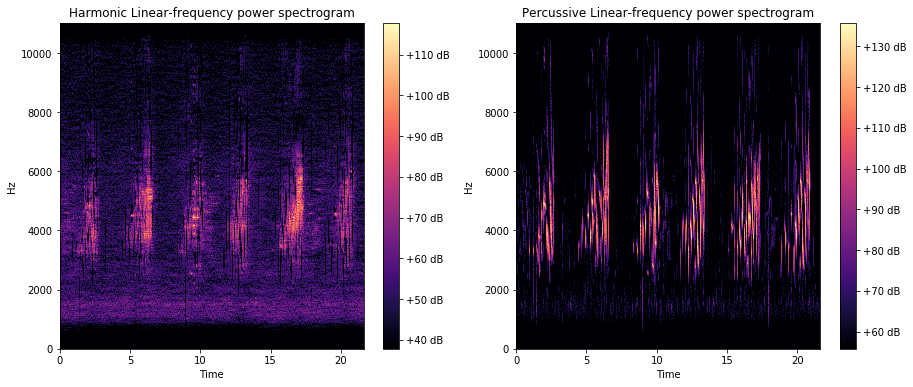

In [47]:
Sound = 1
H1, P1 = librosa.decompose.hpss(FFT[Sound])
H1_db = librosa.amplitude_to_db(H1, ref = 0.00002)
P1_db = librosa.amplitude_to_db(P1, ref = 0.00002)

fig = plt.figure(figsize=(15, 6)) 
plt.subplot(121)
librosa.display.specshow(H1_db, y_axis = 'linear', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Harmonic Linear-frequency power spectrogram')

plt.subplot(122)
librosa.display.specshow(P1_db, y_axis = 'linear', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Percussive Linear-frequency power spectrogram')

<img src="harmonics_percussive.jpg" alt="drawing" width="900"/>

Comments : Harmonic/Percusive filter helps us understand and visualize data. Indeed, it remove redundant information.
Still, we are not satisfied by this filter because it does not remove noises from the spectogram.</p>
Let's add our amplitude filtering.


Text(0.5,1,'Filtered Percussive Linear-frequency power spectrogram')

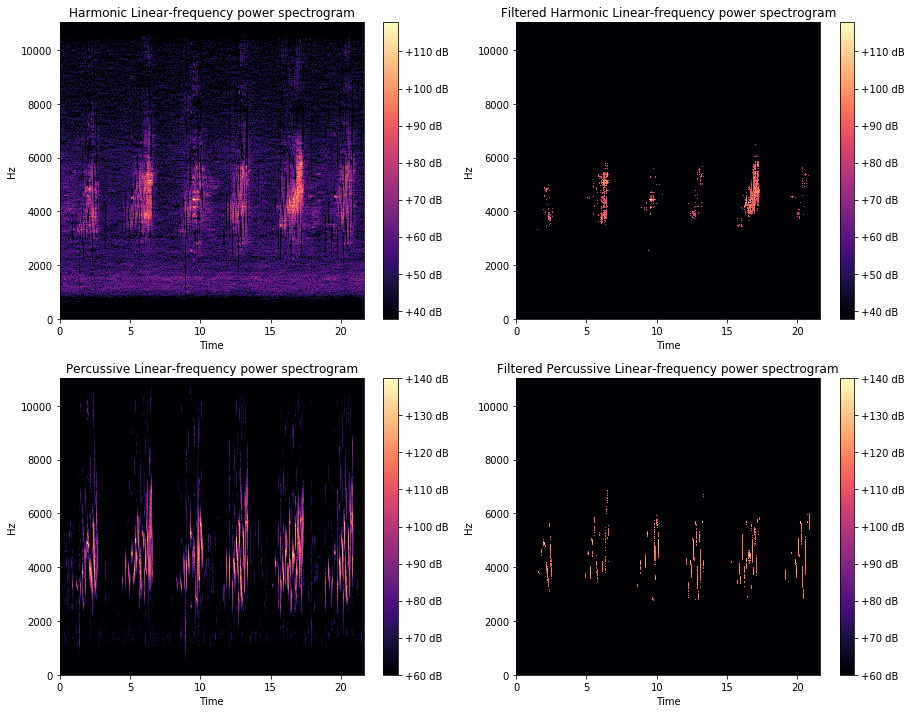

In [48]:
H2, P2 = librosa.decompose.hpss(FFT[Sound])
H2_db = librosa.amplitude_to_db(H2, ref = 0.00002)
P2_db = librosa.amplitude_to_db(P2, ref = 0.00002)
# Amplitude Filters
H2_db[H2_db<np.percentile(H2_db,99)] = np.min(H2_db[:, T])
P2_db[P2_db<np.percentile(P2_db,99)] = np.min(P2_db[:, T])
#Plot
fig = plt.figure(figsize=(15, 12)) 
plt.subplot(2,2,1)
librosa.display.specshow(H1_db, y_axis = 'linear', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Harmonic Linear-frequency power spectrogram')
plt.subplot(2,2,2)
librosa.display.specshow(H2_db, y_axis = 'linear', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Filtered Harmonic Linear-frequency power spectrogram')
plt.subplot(2,2,3)
librosa.display.specshow(P1_db, y_axis = 'linear', x_axis='time')
plt.clim(60,140)
plt.colorbar(format='%+2.0f dB')
plt.title('Percussive Linear-frequency power spectrogram')
plt.subplot(2,2,4)
librosa.display.specshow(P2_db, y_axis = 'linear', x_axis='time')
plt.clim(60,140)
plt.colorbar(format='%+2.0f dB')
plt.title('Filtered Percussive Linear-frequency power spectrogram')

With those filter we can identify a single group of high amplitude harmonic frequencies. This group repeat itself few times as percussive.</p>
Percussives spectrogram hes to understand data because noises are concentrated in harmonics.</p>
Only frequencies that correspond to the bird ones are shown on the percissive spectrogram.
This part was about clearly understand the effects of filter and giving intuitions of spectrums.</p>


We are now able to use more sofisticated filters and visualize results.

### Improvement : more efficient filters
#### NN Filter : nearest neighbour

Text(0.5,1,'Filtered Linear-frequency power spectrogram')

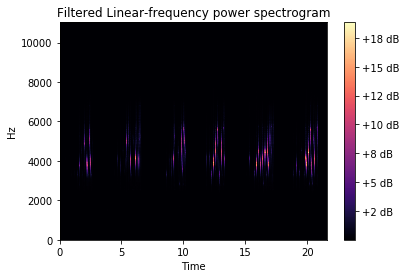

In [50]:
Sound = 1
Filtered_FFT = librosa.decompose.nn_filter(FFT[Sound])
librosa.display.specshow(Filtered_FFT, y_axis = 'linear', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Filtered Linear-frequency power spectrogram')


The NN_filter use nearest neighbour to remove noises from a song. Here what we observ is only the bird sound. 
Unexpected noises should has been removed.

# III. Kasios sounds classification

In [51]:
import re
import pandas as pd
import numpy as np

In [103]:
# data1 = pd.read_csv('/media/comecothenet/TOSHIBA EXT/M2_Datascience/Vizualisation/2018 Mini-Challenge 1/test0_175.csv')
# data2 = pd.read_csv('/media/comecothenet/TOSHIBA EXT/M2_Datascience/Vizualisation/2018 Mini-Challenge 1/test176_257.csv')
# data3 = pd.read_csv('/media/comecothenet/TOSHIBA EXT/M2_Datascience/Vizualisation/2018 Mini-Challenge 1/test258_324.csv')
# data4 = pd.read_csv('/media/comecothenet/TOSHIBA EXT/M2_Datascience/Vizualisation/2018 Mini-Challenge 1/test325_436.csv')
# data5 = pd.read_csv('/media/comecothenet/TOSHIBA EXT/M2_Datascience/Vizualisation/2018 Mini-Challenge 1/test437_520.csv')
# data6 = pd.read_csv('/media/comecothenet/TOSHIBA EXT/M2_Datascience/Vizualisation/2018 Mini-Challenge 1/test521_549.csv')
# data7 = pd.read_csv('/media/comecothenet/TOSHIBA EXT/M2_Datascience/Vizualisation/2018 Mini-Challenge 1/test550_591.csv')
# data8 = pd.read_csv('/media/comecothenet/TOSHIBA EXT/M2_Datascience/Vizualisation/2018 Mini-Challenge 1/test592_619.csv')
# data = pd.concat([data1, data2, data3, data4, data5, data6, data7, data8])
# data.to_csv('/media/comecothenet/TOSHIBA EXT/M2_Datascience/Vizualisation/2018 Mini-Challenge 1/data.csv')

data = pd.read_csv('data.csv')
kasios = pd.read_csv('kasios_wav.csv')

In [104]:
train=pd.read_csv(path + "AllBirdsv4.csv")
train.rename(columns={'File ID': 'File_ID'}, inplace=True)
#print (train)

In [105]:
data['id'] = np.array([(data['sound'][i].split("-")[-1]).split(".")[0] for i in range (len(data))]).astype(int)

In [106]:
data = data.drop(labels='id', axis =1)
data.isnull().sum()
data = data.dropna(how = 'all', axis=1)
data = data.dropna(how= 'any')
data = data.reset_index(drop=True)

In [107]:
testBird = pd.DataFrame()
testBird['isRCBP'] = data['sound']

In [108]:
data['bird']=data['sound']
for i in data.index : 
#     print(i)
#     print(re.search('.+(?=-\d+)', data['sound'].iloc[i]).group(0).replace('-', ' '))
    data['bird'].iloc[i] = re.search('.+(?=-\d+)', data['sound'].iloc[i]).group(0).replace('-', ' ')
    if data['bird'].iloc[i] == 'Rose Crested Blue Pipit' :
        testBird['isRCBP'].iloc[i] = True
    else : 
        testBird['isRCBP'].iloc[i] = False

k_names = pd.DataFrame()
k_names['bird'] = kasios['sound']

In [109]:
data = data.drop(['sound', 'Unnamed: 0'], axis=1)

In [110]:
data.describe()

,duration,voiced,ampl_mean,ampl_median,ampl_sd,amplVoiced_mean,amplVoiced_median,amplVoiced_sd,dom_mean,dom_median,...,quartile25_sd,quartile50_mean,quartile50_median,quartile50_sd,quartile75_mean,quartile75_median,quartile75_sd,specSlope_mean,specSlope_median,specSlope_sd
count,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,...,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000
mean,51.310127,0.229583,0.044451,0.023212,0.056627,0.133419,0.114900,0.078939,2500.756167,2457.144151,...,648.925466,3533.772700,3548.919172,604.752076,4028.218647,4030.307900,563.604730,0.000453,0.000305,0.000669
std,63.530730,0.194611,0.032686,0.029555,0.026712,0.048057,0.048795,0.034348,1219.170163,1365.314888,...,353.937292,942.612297,1042.612694,339.710441,854.106447,939.611212,299.236174,0.000724,0.000639,0.000437
min,1.776327,0.000948,0.002688,0.000142,0.006162,0.046331,0.041490,0.007835,138.340581,120.054446,...,17.638342,235.561376,200.090744,66.218794,978.739327,700.317604,58.197000,-0.002286,-0.001873,0.000028
25%,17.554286,0.098453,0.023201,0.005582,0.037507,0.098839,0.078744,0.055177,1663.505031,1525.691924,...,403.252570,2919.807555,2901.315789,370.181613,3478.487401,3401.542650,355.589249,-0.000039,-0.000088,0.000333
50%,33.275401,0.175161,0.036439,0.013255,0.052455,0.125327,0.104153,0.073562,2521.300734,2520.000000,...,561.426004,3604.076444,3606.635662,521.094593,4142.291159,4126.871597,505.794316,0.000371,0.000206,0.000593
75%,61.499163,0.295408,0.054911,0.028104,0.070386,0.159936,0.139283,0.098282,3266.639775,3301.122958,...,826.919108,4216.885359,4301.463249,761.233164,4615.845027,4682.123412,718.489259,0.000880,0.000638,0.000872
max,602.184000,1.000000,0.266267,0.255814,0.199926,0.352665,0.312206,0.261159,6605.957447,7060.000000,...,2277.356256,5560.278678,5662.568058,2441.256507,5831.533575,5852.654265,2398.822944,0.003190,0.003483,0.002551


#  Machine Learning

We had trained two different classifiers :

- RandomForest Classifier
- DecisionTree Classifier

###  Random Forest 

In [111]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
X_train, X_test, y_train, y_test = train_test_split(data.drop('bird', axis=1), testBird, test_size=0.3)

<BarContainer object of 68 artists>

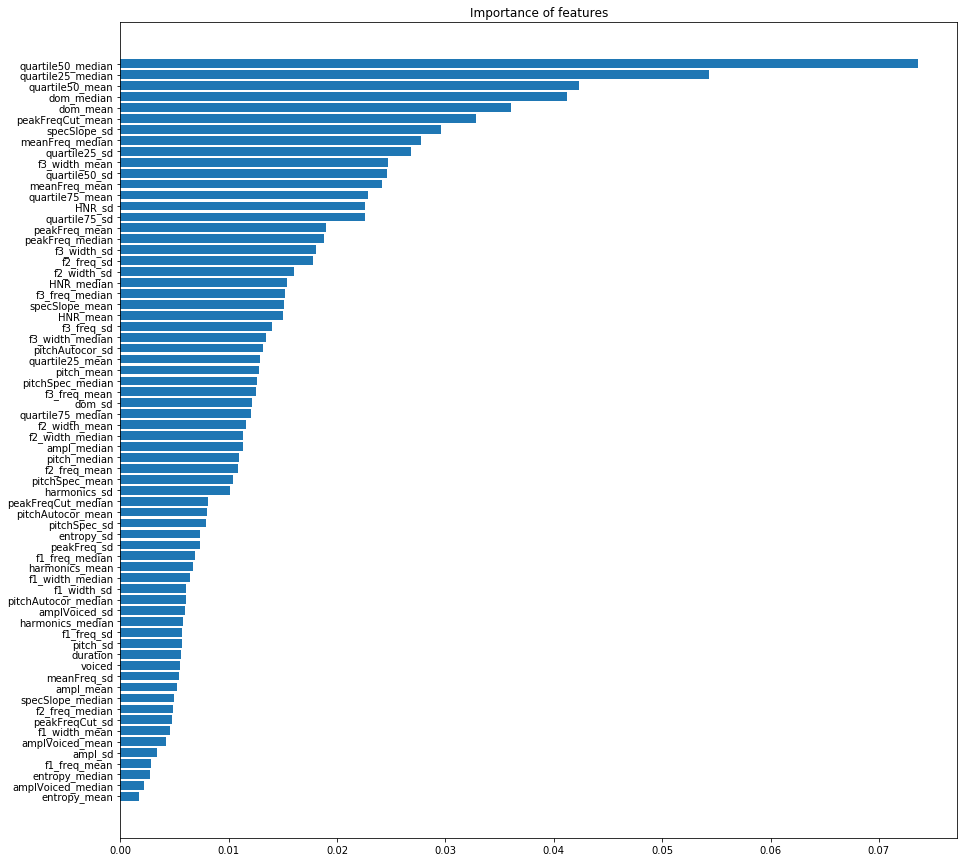

In [125]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced')
rf.fit(X_train, y_train)
importance = pd.DataFrame({'feature' :  data.drop('bird', axis=1).columns, 'importance' : rf.feature_importances_}).sort_values('importance')
fig = plt.figure(figsize=(15, 15))
plt.title('Importance of features')
plt.barh(importance['feature'], importance['importance'])

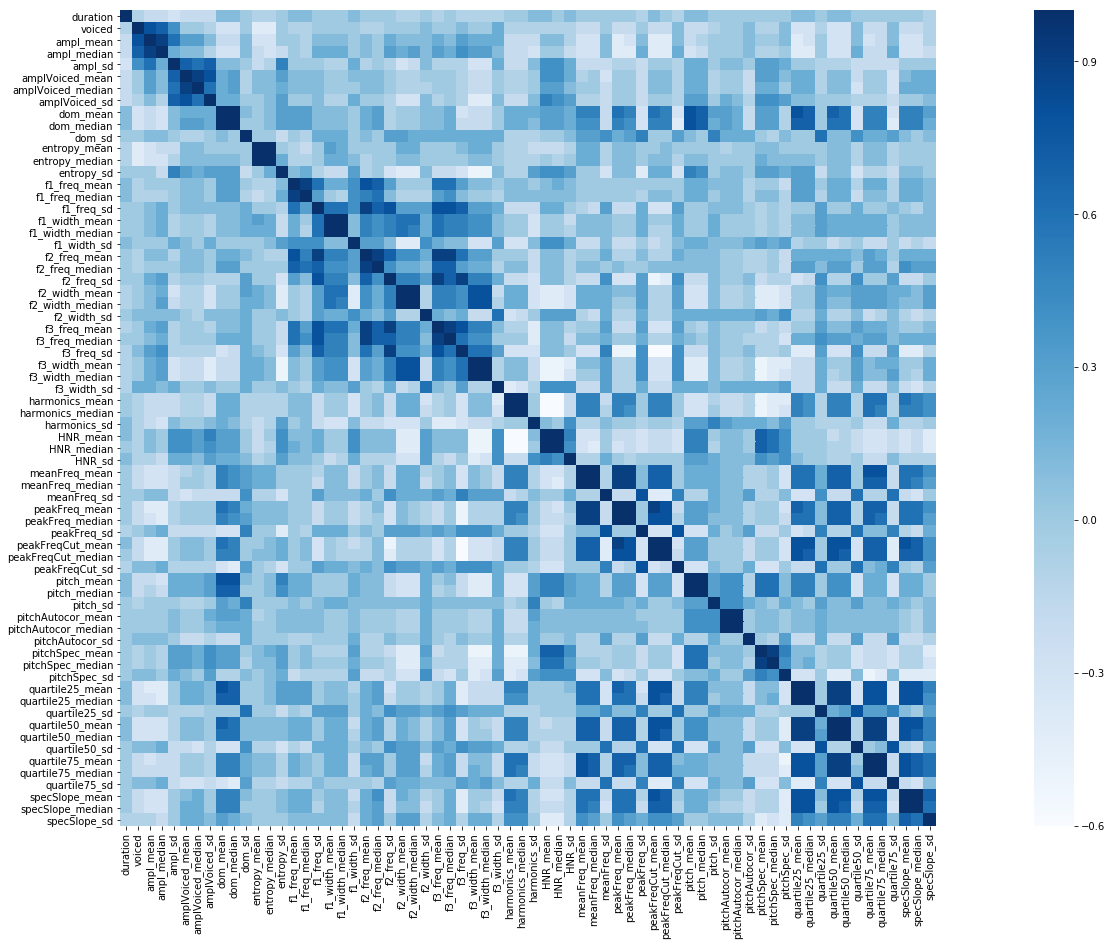

In [113]:
import seaborn as sns
fig = plt.figure(figsize=(35, 15))
plt.title('Correlation of each feature')
sns.heatmap(data.corr().round(1), annot = False, cmap = 'Blues', square=True)

###  Feature selection

Some features are not important so can be dropped

In [114]:
imp_data = data.drop(importance[importance['importance']<0.0001]['feature'], axis=1)
importance = importance.drop(importance[importance['importance']<0.0001].index)
imp_data.head()

,duration,voiced,ampl_mean,ampl_median,ampl_sd,amplVoiced_mean,amplVoiced_median,amplVoiced_sd,dom_mean,dom_median,...,quartile50_mean,quartile50_median,quartile50_sd,quartile75_mean,quartile75_median,quartile75_sd,specSlope_mean,specSlope_median,specSlope_sd,bird
0,13.531429,0.148148,0.057531,0.032258,0.079495,0.214657,0.201717,0.113032,2237.264632,2821.279492,...,3105.158235,3101.406534,306.495188,3475.826338,3541.606171,209.184365,0.000002,-0.000004,0.000213,Bent Beak Riffraff
1,20.950204,0.167264,0.029621,0.011322,0.055531,0.126159,0.096791,0.083782,2194.995463,2015.914247,...,2834.571234,2831.284029,277.561315,3147.713249,3111.411071,301.606427,-0.000142,-0.000119,0.000222,Bent Beak Riffraff
2,22.125714,0.075792,0.018435,0.004322,0.055704,0.179249,0.141943,0.113151,2898.030718,2881.306715,...,3043.768454,3081.397459,251.136588,3218.175908,3201.451906,211.945038,0.000070,0.000062,0.000156,Bent Beak Riffraff
3,11.807347,0.250531,0.055249,0.029940,0.058515,0.132757,0.122095,0.071916,1321.720109,800.362976,...,3537.293870,3961.796733,1038.599121,4106.345047,4381.987296,739.392710,0.000323,0.000327,0.000733,Blue collared Zipper
4,10.968000,0.627002,0.072359,0.059395,0.072294,0.111988,0.100376,0.063695,2797.224335,2660.000000,...,4151.954023,4180.000000,414.002524,4573.639847,4580.000000,447.279994,0.001098,0.000867,0.000833,Blue collared Zipper


In [115]:
y_pred_rf = rf.predict(X_train)
y_predprob_rf = rf.predict_proba(X_train)

from sklearn.metrics import *
import seaborn as sns
print(confusion_matrix(y_train, y_pred_rf))
print("accuracy = {}".format(accuracy_score(y_train, y_pred_rf)))
print("recall = {}".format(recall_score(y_train, y_pred_rf)))
print("precision = {}".format(precision_score(y_train, y_pred_rf)))

[[405   0]
 [  0  38]]
accuracy = 1.0
recall = 1.0
precision = 1.0


##  Decision Tree

### Let's find the best pruning parameter

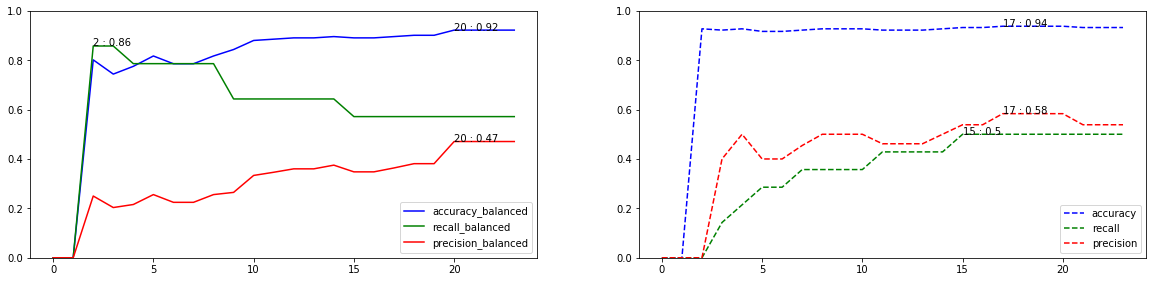

In [116]:
from sklearn.tree import DecisionTreeClassifier
import numpy as np
acc=np.zeros(24)
rec=np.zeros(24)
prec=np.zeros(24)
acc_b=np.zeros(24)
rec_b=np.zeros(24)
prec_b=np.zeros(24)
for i in range(2,24) :
    dt = DecisionTreeClassifier(random_state=0, max_leaf_nodes=i, class_weight='balanced')
    dt = dt.fit(X_train, y_train)
    y_pred_dt = dt.predict(X_test)
    acc_b[i] = accuracy_score(y_test, y_pred_dt)
    rec_b[i] = recall_score(y_test, y_pred_dt)
    prec_b[i] = precision_score(y_test, y_pred_dt)
    
    dt = DecisionTreeClassifier(random_state=0, max_leaf_nodes=i)
    dt = dt.fit(X_train, y_train)
    y_pred_dt = dt.predict(X_test)
    acc[i] = accuracy_score(y_test, y_pred_dt)
    rec[i] = recall_score(y_test, y_pred_dt)
    prec[i] = precision_score(y_test, y_pred_dt)
    
fig=plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(2,2,1)
ax1.set_ylim(0,1)
plt.plot(acc_b, label='accuracy_balanced', color='blue')
plt.annotate(str(np.argmax(acc_b))+" : " + str(np.max(acc_b).round(2)), xy=(np.argmax(acc_b), max(acc_b)))
plt.plot(rec_b, label='recall_balanced', color='green')
plt.annotate(str(np.argmax(rec_b))+" : " + str(np.max(rec_b).round(2)), xy=(np.argmax(rec_b), max(rec_b)))
plt.plot(prec_b, label='precision_balanced', color='red')
plt.annotate(str(np.argmax(prec_b))+" : " + str(np.max(prec_b).round(2)), xy=(np.argmax(prec_b), max(prec_b)))
plt.legend()

ax2 = fig.add_subplot(2,2,2)
ax2.set_ylim(0,1)
plt.plot(acc, "--", label='accuracy', color='blue')
plt.annotate(str(np.argmax(acc))+" : " + str(np.max(acc).round(2)), xy=(np.argmax(acc), max(acc)))
plt.plot(rec,"--", label='recall', color='green')
plt.annotate(str(np.argmax(rec))+" : " + str(np.max(rec).round(2)), xy=(np.argmax(rec), max(rec)))
plt.plot(prec,"--", label='precision', color='red')
plt.annotate(str(np.argmax(prec))+" : " + str(np.max(prec).round(2)), xy=(np.argmax(prec), max(prec)))

plt.legend()


###  Training of the tree

In [117]:

dt = DecisionTreeClassifier(random_state=0, max_leaf_nodes=np.argmax(prec))
dt = dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print(confusion_matrix(y_test, y_pred_dt))
print("accuracy = {}".format(accuracy_score(y_test, y_pred_dt)))

print("recall = {}".format(recall_score(y_test, y_pred_dt)))
print("precision = {}".format(precision_score(y_test, y_pred_dt)))

[[172   5]
 [  7   7]]
accuracy = 0.93717277486911
recall = 0.5
precision = 0.5833333333333334


###  Let's plot the tree :

<img src="tree_classification.png" alt="drawing" width="700"/>

In [ ]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image
import pydotplus 


dot_data = StringIO()

export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
               label='all',
               class_names=['False', 'True'],
               feature_names=data.columns.drop('bird'))

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Thanks to correlation matrices, we can see that features are highly correlated. Therefore, we do not need take all of them in account.

##  Classification of birds songs

In [71]:
try :
    kasios = kasios.drop(['sound', 'Unnamed: 0'], axis=1)
except KeyError :
    print('Colonnes déjà supprimées')

In [72]:
kasios = kasios.dropna(how='all',axis=1)
kasios.describe()

,duration,voiced,ampl_mean,ampl_median,ampl_sd,amplVoiced_mean,amplVoiced_median,amplVoiced_sd,dom_mean,dom_median,...,quartile25_sd,quartile50_mean,quartile50_median,quartile50_sd,quartile75_mean,quartile75_median,quartile75_sd,specSlope_mean,specSlope_median,specSlope_sd
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,...,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,67.056230,0.276943,0.049069,0.020934,0.069430,0.151861,0.139064,0.089007,2858.113210,2857.962795,...,633.521991,3497.132341,3493.584392,551.494894,3912.659160,3956.460980,509.801317,0.000392,0.000252,0.000675
std,30.119159,0.234001,0.039246,0.030278,0.030325,0.073967,0.085511,0.034095,1044.109592,1109.200258,...,336.211607,1195.783956,1230.721903,359.297436,1250.149446,1317.248265,394.629775,0.000860,0.000757,0.000385
min,30.648889,0.100167,0.016192,0.000495,0.033812,0.082235,0.061932,0.047965,1309.789411,1160.526316,...,107.706612,1515.647368,1520.689655,49.843553,1573.833757,1560.707804,81.032660,-0.001078,-0.001128,0.000108
25%,46.972517,0.139297,0.025258,0.002898,0.049444,0.105033,0.089077,0.063487,2189.190932,2080.943739,...,344.981442,2554.069919,2611.184211,263.243773,3175.541919,3081.397459,172.670197,-0.000239,-0.000232,0.000381
50%,58.331429,0.169501,0.038940,0.005350,0.060311,0.121774,0.104351,0.077670,2767.243524,2661.206897,...,810.512930,3580.635278,3481.578947,526.184131,4093.177071,4161.887477,338.496350,0.000510,0.000202,0.000709
75%,79.582766,0.290867,0.047631,0.027189,0.083723,0.177675,0.158411,0.107209,3635.349842,3601.633394,...,860.225264,4372.017462,4341.969147,866.153155,4831.953103,5052.291289,860.531381,0.001160,0.000814,0.000914
max,151.867211,0.879010,0.162531,0.092267,0.140861,0.368507,0.386387,0.154131,4539.309829,4632.100726,...,1114.540617,5163.250701,5222.368421,1145.734916,5492.798363,5502.495463,1172.510488,0.001558,0.001442,0.001287


In [73]:
rf.predict(kasios)

array([False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False,  True])

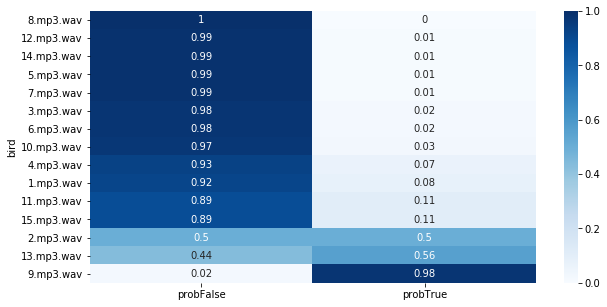

In [123]:
try :
    kasios = kasios.drop(['sound', 'Unnamed: 0'], axis=1)
except KeyError : 
    pass

kasios = kasios.dropna(how='all', axis=1)
kasios.describe()

proba = pd.DataFrame(rf.predict_proba(kasios), columns=['probFalse','probTrue']).set_index(k_names['bird']).sort_values('probTrue')
fig = plt.figure(figsize=(10, 5))
sns.heatmap(proba, cmap='Blues', annot=True)

In [75]:
dt.predict(kasios)

array([False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False,  True])

In [76]:
dt.predict_proba(kasios)

array([[0.97911227, 0.02088773],
       [0.97911227, 0.02088773],
       [0.82857143, 0.17142857],
       [0.97911227, 0.02088773],
       [0.16      , 0.84      ],
       [0.97911227, 0.02088773],
       [0.97911227, 0.02088773],
       [0.97911227, 0.02088773],
       [0.97911227, 0.02088773],
       [0.97911227, 0.02088773],
       [0.97911227, 0.02088773],
       [0.97911227, 0.02088773],
       [0.97911227, 0.02088773],
       [0.97911227, 0.02088773],
       [0.16      , 0.84      ]])

#  Feature visualization


"amplVoiced_mean","entropy_median","f1_freq_median", "f1_width_median", "f1_width_sd","peakFreq_mean", "pitchAutocor_mean”, "pitchAutocor_sd", "specSlope_sd" and "voiced" are the features that will be kept for visualization.

In [164]:
#plot_data = data[["amplVoiced_mean","entropy_median","f1_freq_median", "f1_width_median", "f1_width_sd","peakFreq_mean", "pitchAutocor_mean", "pitchAutocor_sd", "specSlope_sd", "voiced"]]
plot_data = data[["amplVoiced_mean","entropy_median","f1_freq_median", "f1_width_median","peakFreq_mean", "pitchAutocor_mean", "voiced"]]
#plot_kasios = kasios[["amplVoiced_mean","entropy_median","f1_freq_median", "f1_width_median", "f1_width_sd","peakFreq_mean", "pitchAutocor_mean", "pitchAutocor_sd", "specSlope_sd", "voiced"]]
plot_kasios = kasios[["amplVoiced_mean","entropy_median","f1_freq_median", "f1_width_median","peakFreq_mean", "pitchAutocor_mean", "voiced"]]
from matplotlib.pyplot import cm
import numpy as np

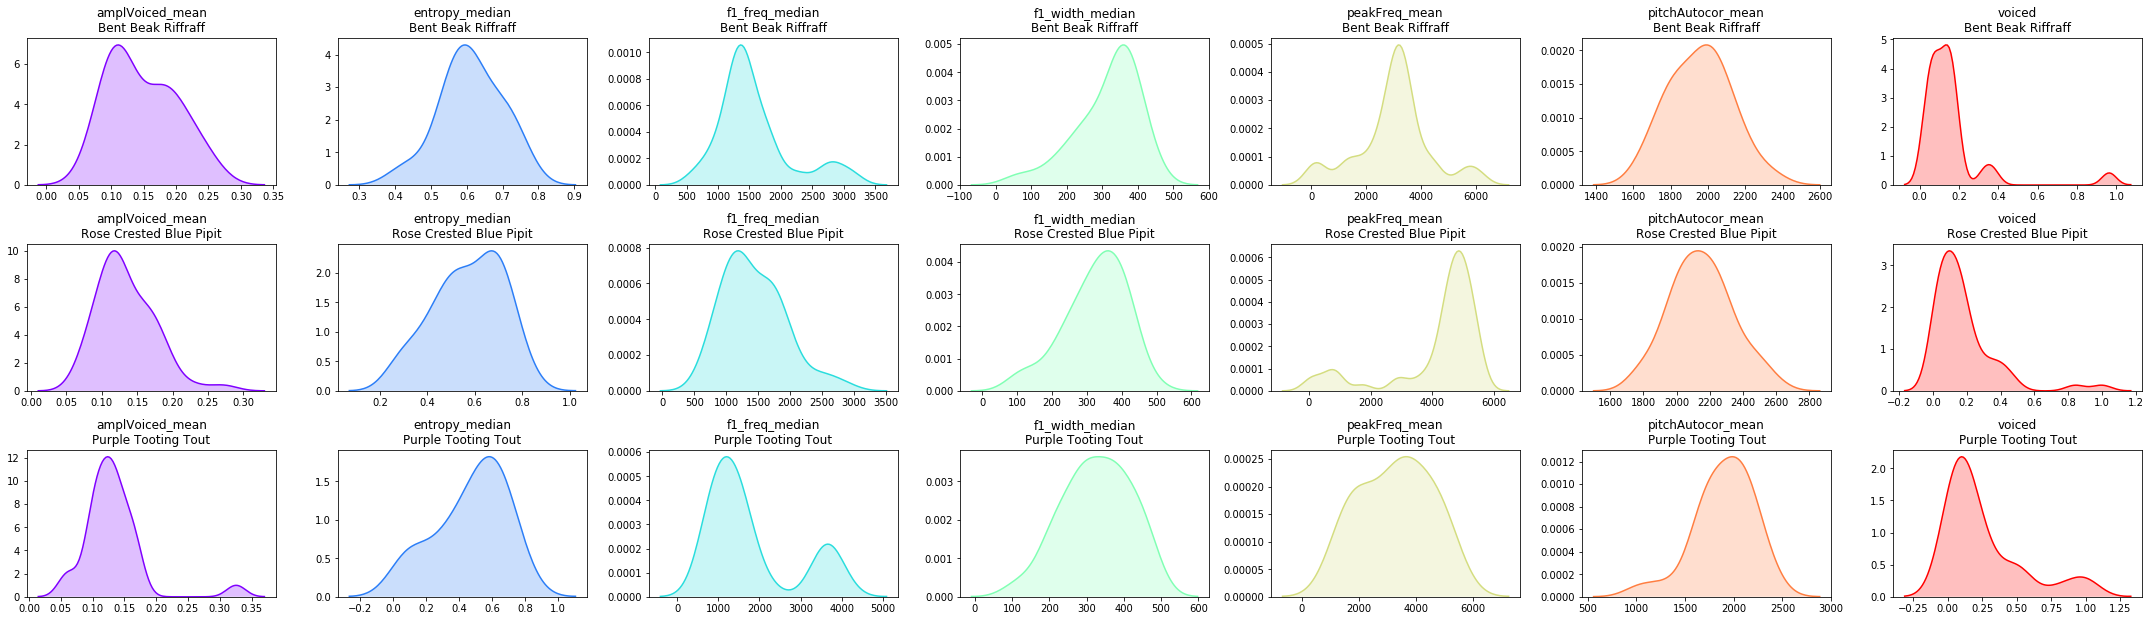

In [172]:
color=cm.rainbow(np.linspace(0,1,7))
fig = plt.figure(figsize= (30, 100))
i=1
for name in data['bird'].unique()[[0, -3, 13]] :
    for col, colour in zip(plot_data.columns, color) :
        ax = fig.add_subplot(35, 7, i)
        sns.kdeplot(plot_data[data['bird']==name][col], shade=True, legend=False, color=colour, label=name +" " + col)
        ax.set_title(col + "\n" + name)
        plt.tight_layout()
        i += 1

In [171]:
plot_kasios.iloc[[9,13],:]

,amplVoiced_mean,entropy_median,f1_freq_median,f1_width_median,peakFreq_mean,pitchAutocor_mean,voiced
9,0.128087,0.464451,1931.83,120.070163,3638.905199,1819.568371,0.166667
13,0.117676,0.405471,1957.96,148.153458,4326.411530,1983.924919,0.144553


In [83]:
output_notebook()

##Import and Clean AllBirds
geo = pd.read_csv("AllBirdsv4.csv")
geo['Vocalization_type'] = geo['Vocalization_type'].str.strip()
geo['Vocalization_type'] = geo['Vocalization_type'].str.lower()
geo['Vocalization_type'] = geo['Vocalization_type'].replace('?', None)
geo['Vocalization_type'].unique()
geo['Date'] = pd.to_datetime(geo['Date'], format='%m/%d/%Y', errors='coerce')
geo['cod_English_name'] = pd.Categorical(geo['English_name']).codes
geo['cod_Vocalization_type'] = pd.Categorical(geo['Vocalization_type']).codes
geo['cod_Quality'] = pd.Categorical(geo['Quality']).codes
geo['Y'] = pd.to_numeric(geo['Y'], errors='coerce')
geo['Year'] = geo['Date'].dt.year
geo['Distance_kasios'] = ((geo['X']-148)**2+(geo['Y']-159)**2)**0.5
geo['Diff_date']=(max(geo['Date'])-geo['Date']).dt.days
geo=geo.dropna()

#Add Colors for type of Birds
birds_types = geo['English_name'].sort_values().unique()
n_birds_types = len(birds_types)
birds_types_colors = pd.Series(Category20[n_birds_types], index = birds_types).rename('color')
geo = geo.join(birds_types_colors, on = "English_name") 

# Import Kassios Birds
K_birds=pd.read_csv(r"Test Birds Location.csv", sep=',',header=0)
K_birds.columns=['Id', 'X', 'Y']

startdate = pd.to_datetime(geo['Date'].sort_values().unique()[0])
enddate = pd.to_datetime(geo['Date'].sort_values().unique()[-1])

def bird_map(doc):

    source = ColumnDataSource(data=dict(x=geo['X'], y=geo['Y'], color=geo['color'], date=geo['Date'], English_name = geo['English_name']))
    
    p = figure(title="Map with birds through time", x_range=(0, 200), y_range=(0, 200))
    
    #background image
    
    p.image_url( url=[r"images/compresspng/map.png"],x=0, y=0, w=200, h=200, anchor="bottom_left")
#     p.image_url( url=[r"Lekagul Roadways 2018.bmp"],x=0, y=0, w=200, h=200, anchor="bottom_left")

    hover = HoverTool()
    hover.tooltips = [
        ("Bird type", "@English_name"),
        ("Position", "(@x, @y)"),
    ]
    p.tools.append(hover)
    #points
#     p.circle(x='x', y='y', size=10, color='color', source=source)

    #Add Kassios Birds 
    source_kassios = ColumnDataSource(data=dict(x=K_birds['X'], y=K_birds['Y'], English_name = K_birds['Id']))
    p.scatter(x="x", y="y", size=30, marker="ox", fill_alpha=0.2, line_width=2, source=source_kassios, legend="Kassios Birds")

    #Kassios Entreprise location
    source_dumping = ColumnDataSource(data=dict(x=[148], y=[159], English_name=[""]))
    p.scatter(x="x", y="y", size=50, marker="o+", color="#B22222", fill_alpha=0.2, line_width=2, source=source_dumping, legend="Kassios Entreprise")

    #Widget
    input_bird_types = MultiSelect(title="Species", options= list(birds_types) , size = n_birds_types)
    input_kassios_birds = MultiSelect(title="Kassios_birds", options=["All","1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15"], size = 15)
   
    
#     date_range_slider = DateRangeSlider(title="Date Range: ", start=startdate, end=enddate, value=(startdate, enddate), step=1)
    
    def update(): 
        bird_types = input_bird_types.value
        kassios_birds = input_kassios_birds.value
        
        selector_types = geo['English_name'].isin(bird_types)
#         date_range = date_range_slider.value_as_datetime
#         selector_date = (pd.to_datetime(geo['Date']) > date_range[0]) & ( pd.to_datetime(geo['Date'])<= date_range[1])
#         geo_selected = geo.loc[selector_types & selector_date].copy() # Selection
        geo_selected = geo.loc[selector_types].copy()
        source.data = dict(
            x=geo_selected['X'],
            y=geo_selected['Y'],
            color=geo_selected["color"],
            date=geo_selected["Date"],
            English_name=geo_selected["English_name"],
        )
        p.image_url( url=[r"images/compresspng/map.png"],x=0, y=0, w=200, h=200, anchor="bottom_left")
#         p.image_url( url=[r"Lekagul Roadways 2018.bmp"],x=0, y=0, w=200, h=200, anchor="bottom_left")
        p.scatter(x="x", y="y", size=50, marker="o+", color="#B22222", fill_alpha=0.2, line_width=2, source=source_dumping, legend="Kassios Entreprise")

    
        indice = input_kassios_birds.value
        if any("All" in s for s in indice):
            kassios_selected = K_birds
        else:
            kassios_selected = K_birds.loc[K_birds['Id'].isin(indice)].copy()
            
        source_kassios = dict (
            x=kassios_selected["X"],
            y=kassios_selected["Y"],
            English_name = kassios_selected["Id"]
        )
        
        url = []
        for bird in bird_types:
            u = "images/compresspng/" + bird + ".png"
            url.append(u)
        p.image_url( url=url,x=0, y=0, w=200, h=200, anchor="bottom_left", global_alpha=0.5)
        
        p.scatter(x="x", y="y", size=30, marker="ox", fill_alpha=0.2, line_width=2, source=source_kassios, legend="Kassios Birds")
        p.scatter(x="x", y="y", size=50, marker="o+", color="#B22222", fill_alpha=0.2, line_width=2, source=source_dumping, legend="Kassios Entreprise")

            

    input_bird_types.on_change('value', lambda attr, old, new: update())
    input_kassios_birds.on_change('value', lambda attr, old, new: update())
#     date_range_slider.on_change('value', lambda attr, old, new: update())

#     l = column(row(p,column(input_bird_types,date_range_slider)))
    l = column(row(p,column(input_bird_types, input_kassios_birds)))
    doc.add_root(l)



Loading BokehJS ...

In [84]:
show(bird_map)

# Conclusion

- On the data exploration part we have seen that Queenscoat birds and Blue Pipit birds are highly correlated. However, during the last years, the number of Blue Pipits records has decreased suddenly, it may be caused by the polution of Kassios.
- On the first interactive map we have seen that there are less and less Blue Pipits around Kassios Entreprise.
- With Machine Learning techniques we have seen that kassios birds are unlikely to be Blue Pipits.
- On the density map we have also seen that most of the Kassios Birds are far from the place where Blue Pipits records had been registered.